# Project Gutenberg Cooking Docs

In [1]:
import pandas as pd
import seaborn as sns
from glob import glob # quickly read directory systems (does not sort files same way on all OS!)
import re             # regular expressions
import nltk

In [2]:
%matplotlib inline
sns.set()

In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to /Users/Kobresia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Kobresia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Kobresia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/Kobresia/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

# Define Functions

#### aquire_epubs()

In [7]:
def acquire_epubs(epub_list, OHCO=OHCO):
    
    my_lib = []
    my_doc = []

    for epub_file in epub_list[:-1]:
        # Get info for LIB table
        book_id = int(epub_file.split('_pg')[-1].split('.')[0].replace('b','1'))
        author_yr = epub_file.split('/')[-1].split('_')[0].replace('[0-9]','')
        author_last = author_yr[:-4]
        book_year = int(author_yr[-4:])
        print("BOOK ID", book_id)
        #print(author_last)

        # Import file as lines
        lines = open(epub_file, 'r', encoding='utf-8-sig').readlines()
        df = pd.DataFrame(lines, columns=['line_str'])
        df.index.name = 'line_num'
        df.line_str = df.line_str.str.strip()
        df['book_id'] = str(book_id)

        # Remove cruft
        start = df[df.line_str.str.match(re.compile('\*\*\*\s*START'), 1)].index[0]   
        stop  = df[df.line_str.str.match(re.compile('(\*\*\*)*End of (the )*Project Gutenberg', re.IGNORECASE), 1)].index[0]
        #print('BOOK_ID', book_id, start, stop)
        df = df.iloc[(start+1):stop]

        # Chunk by chapter (no chapters)
        #chap = re.compile('CHAPTER')
        #chap_lines = df.line_str.str.match(chap)
        #chap_nums = [i+1 for i in range(df.loc[chap_lines].shape[0])]
        #df.loc[chap_lines, 'chap_num'] = chap_nums
        #df.chap_num = df.chap_num.ffill()

        # Chunk by section
        sect = re.compile('(PREFACE|INTRODUCTION|Introductory|MENU |CONTENTS|INDEX)[(I|V|\.)]{0,3}$')
        sect_lines = df.line_str.str.match(sect)
        sect_nums = [i+1 for i in range(df.loc[sect_lines].shape[0])]
        print('sect_nums: ', sect_nums, '')
        #print(df.loc[sect_lines].head(), '\n')
        df.loc[sect_lines, 'sect_num'] = sect_nums
        df.sect_num = df.sect_num.ffill()

        # Clean up
        df = df[~df.sect_num.isna()] # Remove chapter heading lines
        df = df.loc[~sect_lines]     # Remove everything before Section 1
        df['sect_num'] = df['sect_num'].astype('int')

        # Group -- Note that we exclude the book level in the OHCO at this point
        df = df.groupby(OHCO[1:2]).line_str.apply(lambda x: '\n'.join(x)).to_frame() # Make big string

        # Split into paragrpahs
        df = df['line_str'].str.split(r'\n\n+', expand=True).stack().to_frame().rename(columns={0:'para_str'})
        df.index.names = OHCO[1:3] # MAY NOT BE NECESSARY UNTIL THE END
        df['para_str'] = df['para_str'].str.replace(r'\n', ' ').str.strip()
        df = df[~df['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs

        # Set index
        df['book_id'] = book_id
        df = df.reset_index().set_index(OHCO[:3])

        # Register
        my_lib.append((book_id, author_last, book_year, epub_file))
        my_doc.append(df)    
    
    docs = pd.concat(my_doc)
    library = pd.DataFrame(my_lib, columns=['book_id', 'author_last', 'book_year', 'book_file']).set_index('book_id')
    print("Done.")
    return library, docs   

#### tokenize()

In [12]:
def tokenize(doc_df, OHCO=OHCO, remove_pos_tuple=False, ws=False):
    
    # Paragraphs to Sentences
    df = doc_df.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    
    # Sentences to Tokens
    # Local function to pick tokenizer
    def word_tokenize(x):
        if ws:
            s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
        else:
            s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x))) # Discards stuff in between
        return s
            
    df = df.sent_str\
        .apply(word_tokenize)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    
    # Grab info from tuple
    df['pos'] = df.pos_tuple.apply(lambda x: x[1])
    df['token_str'] = df.pos_tuple.apply(lambda x: x[0])
    if remove_pos_tuple:
        df = df.drop('pos_tuple', 1)
    
    # Add index
    df.index.names = OHCO
    
    return df

# Import File

In [4]:
file_dir = 'Various/'
new_dir = 'Various/tables/'
#OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
OHCO = ['book_id', 'sect_num', 'para_num', 'sent_num', 'token_num']

## Find beginning

In [5]:
epub_list = [epub for epub in sorted(glob(file_dir+'/*.txt'))]
epub_list

['Various/Boland1893_Invalid_pg54568.txt',
 'Various/Bradley1923_FLSG_pg10582.txt',
 'Various/Bury1844_TLOCB_pg29232.txt',
 'Various/Eaton1822_TCHCUD_pg29084.txt',
 'Various/Francatelli1852_PCBWC_pg22114.txt',
 'Various/Goudiss1918_War_pg15464.txt',
 'Various/Hill1909_SSCDD_pg19077.txt',
 'Various/Hiller1913_FSD_pg31534.txt',
 'Various/Kitchiner1830_TCO_pg28681.txt',
 'Various/Kleber1915_Suffrage_pg26323.txt',
 'Various/Leslie1840_DFC_pg9624.txt',
 'Various/Lusk1918_War_pg32472.txt',
 'Various/Murrey1884_Soups_pg25007.txt',
 'Various/Murrey1885_Bfast_pg24205.txt',
 'Various/Murrey1885_Salads_pg24542.txt',
 'Various/Murrey1888_Fish_pg53521.txt',
 'Various/Murrey1891_Curry_pg38464.txt',
 'Various/Nelsons1892_HC_pg29519.txt',
 'Various/Payne1877_CSPC_pg61185.txt',
 'Various/Randolf1860_VAHousewife_pg12519.txt',
 'Various/Reed1916_TMRCB_pg37680.txt',
 'Various/Ronald1901_Century_pg34822.txt',
 'Various/Santiagoe1887_Curry_pg34107.txt',
 'Various/Various1902_LuncheonDishes_pg24384.txt',
 'V

In [6]:
len(epub_list)

31

## Pre-Cleaning

Not run:

```
roman = '[IVXLCM.]+'  # roman numerals
caps = "[A-Z';, -]+" # capital letters
long = "[OneTwoThreeFourFiveSix]"
card = "[FIRSTSECONDTHIRDFOURTHFIFTHSIXTHSEVENTH]"

# done by visual inspection of each novel
chap_pats = {
    26005: {  # Armour's Monthly CookBook
        'start_text': 1,
        'start_line': 205,
        'end_line': 33304, # (Table of) Contents
        'volume': re.compile('^\s*BOOK\s+{}\s*$'.format(roman)),    # BOOK I. TITLE, BOOK II. TITLE, ...
        'chapter': re.compile('^\s*CHAPTER\s+{}\s*$'.format(roman)) # CHAPTER I., CHAPTER II., ...
    },
    54568: {  # A HANDBOOK OF INVALID COOKING
        'start_text': 0,
        'start_line': 163,
        'end_line': 10884,
        'volume': re.compile('^\s*Book\s+{}\s*$'.format(long)),     # Book One, Book Two, ...
        'chapter': re.compile('^\s*Chapter\s+{}\s*$'.format(roman)) # Chapter I/n/nTitle, Chapter II/n/nTitle, ...
    },
    10582: { # For Luncheon and Supper Guests
        'start_text': 0,
        'start_line': 71, 
        'end_line': 2808, # (Table of) Contents
        'volume': re.compile('^\s*BOOK\s+{}\s*$'.format(card)),     # BOOK FIRST., BOOK SECOND., ...
        'chapter': re.compile('^\s*Chapter\s+{}\s*$'.format(roman)) # Chapter I., Chapter II., ...
    }
}
```

In [8]:
LIB, DOC = acquire_epubs(epub_list)

BOOK ID 54568
sect_nums:  [1, 2, 3, 4] 
BOOK ID 10582
sect_nums:  [1, 2, 3, 4, 5, 6, 7, 8] 
BOOK ID 29232
sect_nums:  [1, 2] 
BOOK ID 29084
sect_nums:  [1] 
BOOK ID 22114
sect_nums:  [1, 2] 
BOOK ID 15464
sect_nums:  [1] 
BOOK ID 19077
sect_nums:  [1, 2, 3] 
BOOK ID 31534
sect_nums:  [1, 2] 
BOOK ID 28681
sect_nums:  [1, 2, 3, 4, 5] 
BOOK ID 26323
sect_nums:  [1] 
BOOK ID 9624
sect_nums:  [1, 2] 
BOOK ID 32472
sect_nums:  [1, 2] 
BOOK ID 25007
sect_nums:  [1] 
BOOK ID 24205
sect_nums:  [1] 
BOOK ID 24542
sect_nums:  [1] 
BOOK ID 53521
sect_nums:  [1] 
BOOK ID 38464
sect_nums:  [1] 
BOOK ID 29519
sect_nums:  [1, 2, 3] 
BOOK ID 61185
sect_nums:  [1, 2, 3] 
BOOK ID 12519
sect_nums:  [1, 2, 3] 
BOOK ID 37680
sect_nums:  [1, 2] 
BOOK ID 34822
sect_nums:  [1, 2] 
BOOK ID 34107
sect_nums:  [1] 
BOOK ID 24384
sect_nums:  [1] 
BOOK ID 26005
sect_nums:  [1] 
BOOK ID 9935
sect_nums:  [1, 2, 3, 4] 
BOOK ID 9936
sect_nums:  [1, 2, 3] 
BOOK ID 9937
sect_nums:  [1, 2, 3] 
BOOK ID 9938
sect_nums:  [1,

In [9]:
LIB

,author_last,book_year,book_file
book_id,,,
54568,Boland,1893,Various/Boland1893_Invalid_pg54568.txt
10582,Bradley,1923,Various/Bradley1923_FLSG_pg10582.txt
29232,Bury,1844,Various/Bury1844_TLOCB_pg29232.txt
29084,Eaton,1822,Various/Eaton1822_TCHCUD_pg29084.txt
22114,Francatelli,1852,Various/Francatelli1852_PCBWC_pg22114.txt
15464,Goudiss,1918,Various/Goudiss1918_War_pg15464.txt
19077,Hill,1909,Various/Hill1909_SSCDD_pg19077.txt
31534,Hiller,1913,Various/Hiller1913_FSD_pg31534.txt
28681,Kitchiner,1830,Various/Kitchiner1830_TCO_pg28681.txt


In [10]:
DOC.head()

para_str
book_id sect_num para_num                                                   
54568   2        0                                                    PART I
                 1                                       EXPLANATORY LESSONS
                 2                                                      PAGE
                 3         PREPARATION OF FOOD                           ...
                 4         CHEMICAL AND PHYSICAL CHANGES                 ...

In [11]:
DOC.sample(10)

,,,para_str
book_id,sect_num,para_num,
26323,1,135,Baked Ham (a la Miller)
34822,2,4141,Pare and core the citron; cut it into strips a...
25007,1,136,PURÉE OF CLAMS.--Chop twenty-five large hard-s...
26323,1,461,Man doth not live by bread alone. --Owen Meredith
29232,2,1958,_Apple Cheese._
28681,4,507,The following observations were written expres...
37680,1,3249,Soak half a package of gelatine in a cupful of...
54568,3,1470,"Further, bacteria, by their multiplication, us..."
29519,2,280,STRAWBERRY CREAM.


## Tokenize & Annotate

In [13]:
%%time
TOKEN = tokenize(DOC, ws=False)
#CPU times: user 3min 42s, sys: 9.6 s, total: 3min 51s
#Wall time: 3min 52s

CPU times: user 3min 36s, sys: 6.87 s, total: 3min 42s
Wall time: 3min 43s


In [16]:
TOKEN.head()

pos_tuple  pos  \
book_id sect_num para_num sent_num token_num                            
54568   2        0        0        0                  (PART, NN)   NN   
                                   1                    (I, PRP)  PRP   
                 1        0        0          (EXPLANATORY, NNP)  NNP   
                                   1              (LESSONS, NNP)  NNP   
                 2        0        0                  (PAGE, NN)   NN   

                                                token_str  
book_id sect_num para_num sent_num token_num               
54568   2        0        0        0                 PART  
                                   1                    I  
                 1        0        0          EXPLANATORY  
                                   1              LESSONS  
                 2        0        0                 PAGE

In [17]:
TOKEN[TOKEN.pos.str.match('^NNP')] # noise here with caps

pos_tuple  pos  \
book_id sect_num para_num sent_num token_num                            
54568   2        1        0        0          (EXPLANATORY, NNP)  NNP   
                                   1              (LESSONS, NNP)  NNP   
                 3        0        1                   (OF, NNP)  NNP   
                                   2                 (FOOD, NNP)  NNP   
                 4        0        2             (PHYSICAL, NNP)  NNP   
...                                                          ...  ...   
9939    3        45       0        69                (Wine, NNP)  NNP   
                                   70              (Winter, NNP)  NNP   
                                   73                (Wire, NNP)  NNP   
                                   76            (Colander, NNP)  NNP   
                                   78            (Wrapping, NNP)  NNP   

                                                token_str  
book_id sect_num para_num sent_num token_num               
54568   2        1        0        0          EXPLANATORY  
                                   1              LESSONS  
                 3        0        1                   OF  
                                   2                 FOOD  
                 4        0        2             PHYSICAL  
...                                                   ...  
9939    3        45       0        69                Wine  
                                   70              Winter  
                                   73                Wire  
                                   76            Colander  
                                   78            Wrapping  

[108120 rows x 3 columns]

# Reduce

In [18]:
TOKEN['term_str'] = TOKEN['token_str'].str.lower().str.replace('[\W_]', '')

In [20]:
VOCAB = TOKEN.term_str.value_counts().to_frame()\
    .rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
VOCAB.index.name = 'term_id'

In [21]:
VOCAB['num'] = VOCAB.term_str.str.match("\d+").astype('int')

In [27]:
print('Number of TOKENs = ', TOKEN.shape[0])
print('Number of VOCABs =   ', VOCAB.shape[0])

Number of TOKENs =  2432918
Number of VOCABs =    26055


# Annotate VOCAB

### Add Markers for Integers

In [28]:
VOCAB['has_int'] = 0

In [29]:
VOCAB.has_int[VOCAB['term_str'].str.contains('[0-9]')] = 1 # need to fix warning

/Users/Kobresia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
VOCAB[(VOCAB.has_int == 1)].shape

(1338, 7)

## Add Stopwords

In [30]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [31]:
sw.shape

(179, 1)

In [32]:
VOCAB['stop'] = VOCAB.term_str.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [33]:
VOCAB[VOCAB.stop == 1].sample(10)

,term_str,n,num,has_int,stop
term_id,,,,,
23336,these,2661,0,0,1
25993,your,2062,0,0,1
10031,for,18772,0,0,1
9511,few,2023,0,0,1
23487,through,2352,0,0,1
25707,with,29811,0,0,1
25482,where,792,0,0,1
2421,as,15995,0,0,1
14344,m,157,0,0,1


## Add Stems

In [34]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.term_str.apply(stemmer1.stem)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.term_str.apply(stemmer2.stem)

#from nltk.stem.lancaster import LancasterStemmer
#stemmer3 = LancasterStemmer()
#VOCAB['stem_lancaster'] = VOCAB.term_str.apply(stemmer3.stem)

In [37]:
VOCAB = VOCAB.sort_values(by=['n'], ascending=False)

In [39]:
VOCAB.head(5)

,term_str,n,num,has_int,stop,stem_porter,stem_snowball
term_id,,,,,,,
0,,362105,0,0,0,,
23300,the,118693,0,0,1,the,the
2028,and,83529,0,0,1,and,and
16176,of,82275,0,0,1,of,of
1334,a,70577,0,0,1,a,a


## View Results

In [36]:
%whos

Variable          Type               Data/Info
----------------------------------------------
DOC               DataFrame                                   <...>n[45777 rows x 1 columns]
LIB               DataFrame                   author_last  boo<...>1923_WILCV05_pg9939.txt  
OHCO              list               n=5
PorterStemmer     ABCMeta            <class 'nltk.stem.porter.PorterStemmer'>
SnowballStemmer   ABCMeta            <class 'nltk.stem.snowball.SnowballStemmer'>
TOKEN             DataFrame                                   <...>2432918 rows x 4 columns]
VOCAB             DataFrame                  term_str       n <...>n[26055 rows x 7 columns]
acquire_epubs     function           <function acquire_epubs at 0x126a8da70>
epub_list         list               n=31
file_dir          str                Various/
glob              function           <function glob at 0x100cef4d0>
new_dir           str                Various/tables/
nltk              module             <module 'n

### Reduced VOCAB
(no integers or stopwords)

In [42]:
VOCAB_real = VOCAB[(VOCAB.has_int == 0) & (VOCAB.stop == 0)]
VOCAB_real = VOCAB_real[VOCAB_real.term_str != ''].drop(['num','stop','has_int'], axis=1)

In [63]:
print('Total Num VOCAB   = ', VOCAB.shape[0])
print('Num Reduced VOCAB = ', VOCAB_real.shape[0])

Total Num VOCAB   =  26055
Num Reduced VOCAB =  24577


In [43]:
VOCAB_real.head(20)

,term_str,n,stem_porter,stem_snowball
term_id,,,,
25213,water,11486,water,water
18728,put,9786,put,put
1563,add,8498,add,add
16295,one,8437,one,one
20205,salt,7687,salt,salt
4083,butter,7652,butter,butter
24141,two,7644,two,two
14732,may,7595,may,may
11316,half,6479,half,half


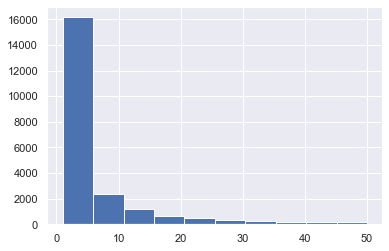

In [44]:
VOCAB_real.n[VOCAB_real.n <= 50].hist();

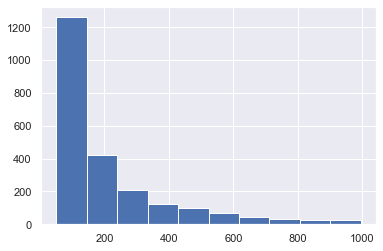

In [45]:
VOCAB_real.n[(VOCAB_real.n > 50) & (VOCAB_real.n <= 1000)].hist();

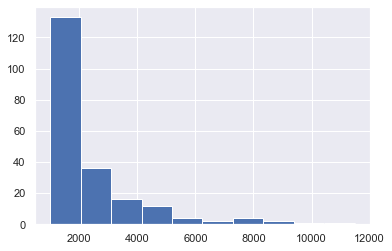

In [46]:
VOCAB_real.n[VOCAB_real.n > 1000].hist();

#### Top Words

In [62]:
i = 100
print('Number of top', i, 'words =', len(VOCAB_real.n[VOCAB_real.n >= i]))
i = 50
print('Number of top', i, 'words = ', len(VOCAB_real.n[VOCAB_real.n >= i]))

Number of top 100 words = 1630
Number of top 50 words =  2547


# Save

In [ ]:
#DOC.to_csv('DOC.csv')
#LIB.to_csv('LIB.csv')
#VOCAB.to_csv('VOCAB.csv')
#TOKEN.to_csv('TOKEN.csv')